# undersanding how to correct perspective

+ [link](https://dev.intelrealsense.com/docs/projection-texture-mapping-and-occlusion-with-intel-realsense-depth-cameras)

In [1]:
import numpy as np
import cv2


To get color camera intrinsics, get sure to have `pyrealsense2` installed with `pip`, then on the CLI:

```ssh
python
```

Then paste the following code:

```python
import pyrealsense2 as rs
import numpy as np
import cv2
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 1920, 1080, rs.format.bgr8, 6)
profile = pipeline.start(config)
frames = pipeline.wait_for_frames()
color_frame = frames.get_color_frame()
intrinsics=color_frame.profile.as_video_stream_profile().intrinsics
print(intrinsics)
```

output:
```ssh
[ 1920x1080  p[955.758 562.48]  f[1363.27 1362.53]  Inverse Brown Conrady [0 0 0 0 0] ]
```


Then once the camera parameters are known, the [deprojection of the pixel](https://github.com/IntelRealSense/librealsense/blob/5e73f7bb906a3cbec8ae43e888f182cc56c18692/include/librealsense2/rsutil.h#L46) can be done:


```C++
/* Given pixel coordinates and depth in an image with no distortion or inverse distortion coefficients, compute the corresponding point in 3D space relative to the same camera */
static void rs2_deproject_pixel_to_point(float point[3], const struct rs2_intrinsics * intrin, const float pixel[2], float depth)
{
    assert(intrin->model != RS2_DISTORTION_MODIFIED_BROWN_CONRADY); // Cannot deproject from a forward-distorted image
    assert(intrin->model != RS2_DISTORTION_FTHETA); // Cannot deproject to an ftheta image
    //assert(intrin->model != RS2_DISTORTION_BROWN_CONRADY); // Cannot deproject to an brown conrady model

    float x = (pixel[0] - intrin->ppx) / intrin->fx;
    float y = (pixel[1] - intrin->ppy) / intrin->fy;
    if(intrin->model == RS2_DISTORTION_INVERSE_BROWN_CONRADY)
    {
        float r2  = x*x + y*y;
        float f = 1 + intrin->coeffs[0]*r2 + intrin->coeffs[1]*r2*r2 + intrin->coeffs[4]*r2*r2*r2;
        float ux = x*f + 2*intrin->coeffs[2]*x*y + intrin->coeffs[3]*(r2 + 2*x*x);
        float uy = y*f + 2*intrin->coeffs[3]*x*y + intrin->coeffs[2]*(r2 + 2*y*y);
        x = ux;
        y = uy;
    }
    point[0] = depth * x;
    point[1] = depth * y;
    point[2] = depth;
}

```

In [151]:
def depth_to_point_cloud(depth_image, rgb_image, intrinsics):

    # image shape
    H, W = depth_image.shape

    '''
    Intrinsic camera matrix for the raw (distorted) images.
        [fx  0 ppx]
    K = [ 0 fy ppy]
        [ 0  0  1]
    Projects 3D points in the camera coordinate frame to 2D pixel
    coordinates using the focal lengths (fx, fy) and principal point
    (cx, cy).
    '''

    # Parametri intrinseci
    f_x, f_y = intrinsics['f_x'], intrinsics['f_y']    
    ppx, ppy = intrinsics['ppx'], intrinsics['ppy']

    # Crea una meshgrid delle coordinate dei pixel
    u, v = np.meshgrid(np.arange(W), np.arange(H))

    # replace 0 with np.nan to avoid errors
    depth_image = np.where(depth_image == 0, np.nan, depth_image)

    # Calcola le coordinate 3D
    X = (u - ppx) / f_x * depth_image
    Y = (v - ppy) / f_y * depth_image
    Z = depth_image


    # Impila le coordinate X, Y, Z
    points = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)

    # Ottieni i valori RGB
    rgb_values = rgb_image.reshape(-1, 3)

    # Combina coordinate e colori in un unico array
    point_cloud = np.hstack((points, rgb_values))


    # reshape the data to have x, y values to navigate the channel values:
    # -  x[mm] (with respect to center of the frame)
    # -  y[mm]
    # -  z[mm]
    # -  red
    # -  green
    # -  blue
    point_cloud2 = point_cloud.reshape((depth_image.shape[0], depth_image.shape[1], len(point_cloud[0])))
  
    return point_cloud2

In [218]:
def shift_pointcloud_origin(point_cloud, xy_origin):
    H, W, _ = point_cloud.shape

    X = point_cloud[:, :, 0]
    Y = point_cloud[:, :, 1]
    Z = point_cloud[:, :, 2]

    # define actual origin coordinates
    Ox = point_cloud[xy_origin[1], xy_origin[0], 0]
    Oy = point_cloud[xy_origin[1], xy_origin[0], 1]
    Oz = point_cloud[xy_origin[1], xy_origin[0], 2]

    # shift the origin
    S = np.array([[1, 0, 0, -Ox],
                 [0, 1, 0, -Oy],
                 [0, 0, 1, -Oz],
                 [0, 0, 0, 1]])
    
    homogeneous_coords = np.stack((X, Y, Z, np.ones_like(X)), axis=-1)
    
    # Reshape to (N, 4) where N = height * width
    homogeneous_coords = homogeneous_coords.reshape(-1, 4)
    # Apply the transformation matrix S
    points_transformed = np.dot(S, homogeneous_coords.T).T
    # Reshape back to the original shape
    points_transformed = points_transformed.reshape(H, W, 4)
    # Extract the transformed X, Y, Z coordinates
    point_cloud[:, :, 0] = points_transformed[:, :, 0]
    point_cloud[:, :, 1] = points_transformed[:, :, 1]
    point_cloud[:, :, 2] = points_transformed[:, :, 2]
    
    return point_cloud

In [219]:
def flip_pointcloud_coords(point_cloud):

    H, W, _ = point_cloud.shape

    X = point_cloud[:, :, 0]
    Y = point_cloud[:, :, 1]
    Z = point_cloud[:, :, 2]

    # shift the origin
    S = np.array([[1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])
    
    # Prepare the point cloud for transformation by adding a column of ones for homogeneous coordinates
    XYZ_coords = np.stack((X, Y, Z, np.ones_like(X)), axis=-1)
    
    # Reshape to (N, 4) where N = H * W
    XYZ_coords = XYZ_coords.reshape(-1, 4)
    
    # Apply the transformation matrix S
    points_transformed = np.dot(XYZ_coords, S.T)
    
    # Reshape back to the original shape
    points_transformed = points_transformed.reshape(H, W, 4)

    # Extract the transformed X, Y, Z coordinates
    point_cloud[:, :, 0] = points_transformed[:, :, 0]
    point_cloud[:, :, 1] = points_transformed[:, :, 1]
    point_cloud[:, :, 2] = points_transformed[:, :, 2]

    
    return point_cloud

(1920, 1080, 6)
[-661.57729371 -291.00551615 -145.        ]


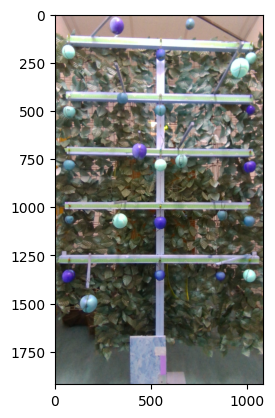

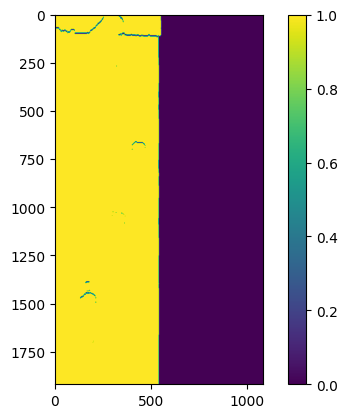

In [237]:
col3D = '../data/3D/1_1_6_0/color_1_6_0.png'
depth3D = '../data/3D/1_1_6_0/depth_1_6_0.png'


col3D = cv2.imread(col3D)
depth3D = cv2.imread(depth3D, cv2.IMREAD_ANYDEPTH)

# matrice K is intrinsics - per proiettare il pixel in punto xyz
# The fx and fy fields describe the focal length of the image, as a multiple of pixel width and height

intrinsics = {'f_x': 1362.53, 
              'f_y': 1363.27,
              'ppx': 562.758, 
              'ppy': 955.758}


point_cloud = depth_to_point_cloud(depth3D, col3D, intrinsics)

# Condition to find where both channel 1 and channel 2 are 0
# condition = (point_cloud[:, :, 0] == 0) & (point_cloud[:, :, 1] == 0)

# Get the positions
# positions = np.argwhere(condition)

# print(point_cloud[[539, 959]] - point_cloud[[546,1770]])


bboxF = np.array([[539, 959], [540, 960]])
bboxT = np.array([[546,1770], [ 575,1871]])


point_cloud = shift_pointcloud_origin(point_cloud, [539, 1750])
point_cloud = flip_pointcloud_coords(point_cloud)


print(point_cloud.shape)
print(point_cloud[ 1919, 0, 0:3])



# print(np.mean(point_cloud[bboxT[0][1] : bboxT[1][1], bboxT[0][0] : bboxT[1][0], 0]))

import matplotlib.pyplot as plt
plt.imshow(col3D)
plt.show()
# pl = plt.imshow(point_cloud[ :, :, 0])
pl = plt.imshow(np.where((point_cloud[ :, :, 0] < 0), 1, 0))
# pl = plt.imshow(np.where((point_cloud[ :, :, 0] < 0) & (point_cloud[:,:,1] < 0), 1, 0))
plt.colorbar(pl)
plt.show()